In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
data_dir = "../data/"

ad       = "advertising_data.csv"
product  = "product_features.csv"
test     = "test_data.csv"

In [3]:
ad_df = pd.read_csv(data_dir + ad)
ad_df.head()

,id,total_impressions,total_clicks
0,256267807759733027,210668,3072
1,256116040854823001,256,1
2,161813552135921143,257,1
3,161706789729706564,514,1
4,161852355376300253,259,1


In [4]:
product_df = pd.read_csv(data_dir + product)
product_df.head()

,id,title,description,unitprice,agegroup,material,pattern,label,imagelink,score
0,z161648047317592213,Masquerade Party Mask Spider Purple Gothic Card,Masquerade Party Mask Gothic Spiders Black Sil...,2.20,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/masquerade_party_mask_s...,0.002072
1,z161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087
2,z161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005
3,z161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620
4,z161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025


In [5]:
test_df = pd.read_csv(data_dir + test)
test_df.head()

,id,total_impressions,total_clicks
0,161470442074827593,515,0
1,161245544788419281,260,0
2,256450282188607023,774,0
3,161892573295168874,280,0
4,161123552659461969,283,0


### Notes on Data

* There are 177,715 data points in the csv file
* Each ID is unique
* Unit Price is in dollars
* Title and Description are from the product page
* Image Link is to the picture of the product
* Score is a web analytics score

In [6]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177715 entries, 0 to 177714
Data columns (total 10 columns):
id             177715 non-null object
title          177715 non-null object
description    177715 non-null object
unitprice      177715 non-null float64
agegroup       29236 non-null object
material       4837 non-null object
pattern        17254 non-null object
label          177715 non-null object
imagelink      177715 non-null object
score          177318 non-null float64
dtypes: float64(2), object(8)
memory usage: 13.6+ MB


In [7]:
product_df.describe()

,unitprice,score
count,177715.000000,1.773180e+05
mean,2.186911,1.307383e-01
std,0.259427,9.680158e-01
min,1.650000,9.544787e-13
25%,2.010000,5.086235e-06
50%,2.160000,2.088163e-05
75%,2.270000,1.129018e-02
max,4.850000,1.000000e+02


Taking a look at what the data looks like

In [8]:
product_df[product_df['score'] > 10]['id'].shape

(249,)

Just to check what the image looks like

In [9]:
product_df.iloc[0]['imagelink']

'https://rlv.zcache.com/masquerade_party_mask_spider_purple_gothic_card-r8195a8e09f6c4d6784b8bd027cf7a13d_6gdus_kxj33_1024.jpg?rlvnet=1&bwm=9e95f47b988f71bd940f7e032e852a6753c9fd24'

In [10]:
product_df.iloc[1]['imagelink']

'https://rlv.zcache.com/baby_girl_shower_card-re96ca7ad58824c26bcb9ce1c4af3c4cb_6gdu5_kxj33_1024.jpg?rlvnet=1&bwm=8f1b4df621b55c1b160cd5181c7ecaec42c3ac40'

In [11]:
product_df.iloc[0]['title']

'Masquerade Party Mask Spider Purple Gothic Card'

In [12]:
product_df.iloc[0]['description']

'Masquerade Party Mask Gothic Spiders Black Silver Purple Mardi Gras. Birthday Announcements for Womans and girls. Gender: unisex.'

In [13]:
id = product_df.iloc[0]['id'][1:]
ad_df[ad_df['id'] == int(id)]

,id,total_impressions,total_clicks


In [14]:
id = product_df.iloc[0]['id'][1:]
test_df[test_df['id'] == int(id)]

,id,total_impressions,total_clicks
184,161648047317592213,28139,0


## Initial Thoughts

* Connect the product dataframe with the ad dataframe and test dataframe
* Text data is important as it contains key features. Mine for keywords or keep whole data?
* Is it worth downloading the images and trying something with them?
* All products are invitation cards.

## Joining the dataframes

I first need to strip the z from each id in product_df

In [15]:
product_df['id'] = product_df['id'].str[1:]
product_df['id'] = pd.to_numeric(product_df['id'])
ad_df['id'] = pd.to_numeric(ad_df['id'])
product_df.head()

,id,title,description,unitprice,agegroup,material,pattern,label,imagelink,score
0,161648047317592213,Masquerade Party Mask Spider Purple Gothic Card,Masquerade Party Mask Gothic Spiders Black Sil...,2.20,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/masquerade_party_mask_s...,0.002072
1,161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087
2,161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005
3,161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620
4,161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025


Next, I need to perform a join between the dataframes.

In [16]:
product_df.set_index('id', inplace = True)
ad_df.set_index('id', inplace = True)

train = product_df.join(ad_df, how = 'inner')
train.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,total_clicks
id,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,1
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,1
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,1
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,1
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,1


In [17]:
train.describe()

,unitprice,score,total_impressions,total_clicks
count,157715.000000,1.573570e+05,1.577150e+05,157715.000000
mean,2.186921,1.311064e-01,6.923090e+03,77.228628
std,0.259407,9.755175e-01,5.996064e+04,813.020416
min,1.650000,9.544787e-13,1.000000e+02,1.000000
25%,2.010000,5.086205e-06,2.560000e+02,2.000000
50%,2.160000,2.091052e-05,5.970000e+02,4.000000
75%,2.270000,1.122725e-02,1.820000e+03,11.000000
max,4.850000,1.000000e+02,1.051868e+07,94066.000000


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157715 entries, 161928552431970573 to 256390066559512928
Data columns (total 11 columns):
title                157715 non-null object
description          157715 non-null object
unitprice            157715 non-null float64
agegroup             25977 non-null object
material             4268 non-null object
pattern              15277 non-null object
label                157715 non-null object
imagelink            157715 non-null object
score                157357 non-null float64
total_impressions    157715 non-null int64
total_clicks         157715 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 14.4+ MB


In [19]:
class ScoreFix(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X['score'].fillna(X['score'].median(), axis = 0, inplace = True)
        return X

In [20]:
train['score'].fillna(train['score'].median(), axis = 0, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157715 entries, 161928552431970573 to 256390066559512928
Data columns (total 11 columns):
title                157715 non-null object
description          157715 non-null object
unitprice            157715 non-null float64
agegroup             25977 non-null object
material             4268 non-null object
pattern              15277 non-null object
label                157715 non-null object
imagelink            157715 non-null object
score                157715 non-null float64
total_impressions    157715 non-null int64
total_clicks         157715 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 14.4+ MB


Now I want to seperate out the rows where I'm supposed to predict the value

In [21]:
test_df.set_index('id', inplace = True)

In [22]:
test = test_df.join(product_df, how = 'inner')
test.head()

,total_impressions,total_clicks,title,description,unitprice,agegroup,material,pattern,label,imagelink,score
id,,,,,,,,,,,
161470442074827593,515,0,Happy 80th Birthday Party Invitation,Perfect for Male or Female ...All Ages availab...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/happy_80th_birthday_par...,0.000009
161245544788419281,260,0,Wisteria Purple Flowers and Fence Wedding Card,This wedding invitation features a photograph ...,3.10,NaN,NaN,NaN,other,https://rlv.zcache.com/wisteria_purple_flowers...,0.000001
256450282188607023,774,0,Blue white modern fashion tie dye striped patt...,Blue white modern fashion tie dye striped patt...,2.01,NaN,NaN,striped,sold_locally,https://rlv.zcache.com/blue_white_modern_fashi...,NaN
161892573295168874,280,0,Rustic Country Barn Wood Wedding Invitations,A rustic country barn wood wedding invitation ...,2.16,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/rustic_country_barn_woo...,0.000063
161123552659461969,283,0,lace pink rose & burlap rehearsal dinner invit...,Beautiful classic rehearsal dinner invitations...,2.26,NaN,lace,NaN,sold_locally,https://rlv.zcache.com/lace_pink_rose_burlap_r...,0.000396


In [23]:
test.describe()

,total_impressions,total_clicks,unitprice,score
count,2.000000e+04,20000.0,20000.000000,1.996100e+04
mean,7.035307e+03,0.0,2.186826,1.278368e-01
std,5.696941e+04,0.0,0.259589,9.067251e-01
min,1.000000e+02,0.0,1.650000,8.008702e-12
25%,2.560000e+02,0.0,2.010000,5.086598e-06
50%,5.980000e+02,0.0,2.160000,2.038401e-05
75%,1.812250e+03,0.0,2.270000,1.170290e-02
max,3.110567e+06,0.0,4.350000,4.386921e+01


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 161470442074827593 to 256143226746912028
Data columns (total 11 columns):
total_impressions    20000 non-null int64
total_clicks         20000 non-null int64
title                20000 non-null object
description          20000 non-null object
unitprice            20000 non-null float64
agegroup             3259 non-null object
material             569 non-null object
pattern              1977 non-null object
label                20000 non-null object
imagelink            20000 non-null object
score                19961 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.8+ MB


## Explore Data

Find out if there are any features I can crete and see if I can spot some relationships in the data

Create a quick click-through rate variable

In [25]:
train['CTR'] = train['total_clicks'] / train['total_impressions']

train.describe()

,unitprice,score,total_impressions,total_clicks,CTR
count,157715.000000,1.577150e+05,1.577150e+05,157715.000000,157715.000000
mean,2.186921,1.308088e-01,6.923090e+03,77.228628,0.008834
std,0.259407,9.744297e-01,5.996064e+04,813.020416,0.007903
min,1.650000,9.544787e-13,1.000000e+02,1.000000,0.000131
25%,2.010000,5.088110e-06,2.560000e+02,2.000000,0.003916
50%,2.160000,2.091052e-05,5.970000e+02,4.000000,0.006695
75%,2.270000,1.112157e-02,1.820000e+03,11.000000,0.010881
max,4.850000,1.000000e+02,1.051868e+07,94066.000000,0.152000


In [26]:
train.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,total_clicks,CTR
id,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,1,0.003906
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,1,0.000977
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,1,0.003891
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,1,0.003876
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,1,0.001946


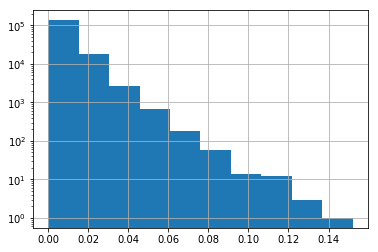

In [27]:
fig, ax = plt.subplots()
train['CTR'].hist()
ax.set_yscale('log')

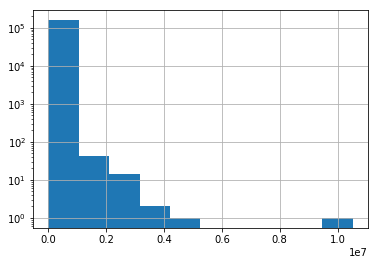

In [28]:
fig, ax = plt.subplots()
train['total_impressions'].hist()
ax.set_yscale('log')

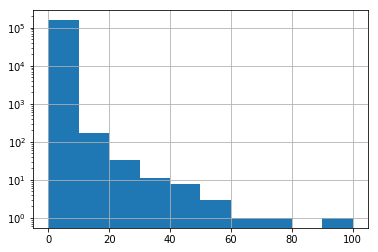

In [29]:
fig, ax = plt.subplots()
train['score'].hist()
ax.set_yscale('log')

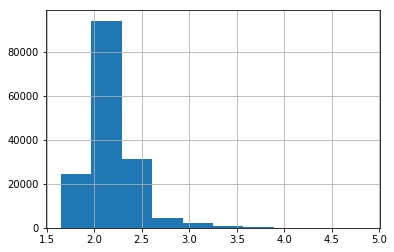

In [30]:
train['unitprice'].hist()

I'm changing the various continuous features into categorical features to see if there is any kind of interesting relationships that I can find.

total_impressions goes from 100     -> 10,500,000

total_clicks      goes from 1       -> 94,066

CTR               goes from .00001  -> 0.15

score             goes from 9.5e-13 -> 100

price             goes from 1.65    -> 4.85

# Transforming the Data

In [31]:
bin_range_imp = np.arange(0, 1.2e7, 0.1e7)
bin_range_clk = np.arange(0, 110_000, 10_000)
bin_range_ctr = np.geomspace(0.000131, 0.152, 10)
bin_range_scr = np.geomspace(9.544786e-13, 100, 10)
bin_range_prc = np.linspace(1.64, 4.86, 10)

In [32]:
copy = train.copy()
copy.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,total_clicks,CTR
id,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,1,0.003906
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,1,0.000977
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,1,0.003891
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,1,0.003876
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,1,0.001946


Creating a transformer to do what I just did

In [33]:
class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_dest = ['score', 'unitprice']):
        self.column_dest = column_dest
        
        bin_range_imp = np.arange(0, 1.2e7, 0.1e7)
        bin_range_scr = np.geomspace(9.544786e-13, 100, 10)
        bin_range_prc = np.linspace(1.64, 4.86, 10)
        
        self.d = {'total_impressions' : bin_range_imp,
            'score' : bin_range_scr,
            'unitprice' : bin_range_prc}
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for c in self.column_dest:
            X[c] = pd.cut(X[c], bins = self.d[c], include_lowest = True)
            
        return X

In [34]:
train['total_impressions_cat'] = pd.cut(train['total_impressions'], bins = bin_range_imp, include_lowest = True)
train['total_clicks_cat']      = pd.cut(train['total_clicks'], bins = bin_range_clk, include_lowest = True)
train['ctr_cat']               = pd.cut(train['CTR'], bins = bin_range_ctr, include_lowest = True)
train['score_cat']             = pd.cut(train['score'], bins = bin_range_scr, include_lowest = True)
train['unitprice_cat']         = pd.cut(train['unitprice'], bins = bin_range_prc, include_lowest = True)

train.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,total_clicks,CTR,total_impressions_cat,total_clicks_cat,ctr_cat,score_cat,unitprice_cat
id,,,,,,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,1,0.003906,"(-0.001, 1000000.0]","(-0.001, 10000.0]","(0.00302, 0.0066]","(5.87e-05, 0.00212]","(1.639, 1.998]"
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,1,0.000977,"(-0.001, 1000000.0]","(-0.001, 10000.0]","(0.000628, 0.00138]","(1.63e-06, 5.87e-05]","(1.998, 2.356]"
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,1,0.003891,"(-0.001, 1000000.0]","(-0.001, 10000.0]","(0.00302, 0.0066]","(5.87e-05, 0.00212]","(1.998, 2.356]"
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,1,0.003876,"(-0.001, 1000000.0]","(-0.001, 10000.0]","(0.00302, 0.0066]","(1.63e-06, 5.87e-05]","(1.998, 2.356]"
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,1,0.001946,"(-0.001, 1000000.0]","(-0.001, 10000.0]","(0.00138, 0.00302]","(1.63e-06, 5.87e-05]","(2.356, 2.713]"


In [35]:
train['score_cat'].value_counts(dropna = False)

(1.63e-06, 5.87e-05]                  73229
(0.00212, 0.0766]                     31477
(0.0766, 2.768]                       20975
(5.87e-05, 0.00212]                   20443
(4.5e-08, 1.63e-06]                    9210
(2.768, 100.0]                         1400
(1.25e-09, 4.5e-08]                     823
(3.45e-11, 1.25e-09]                    150
(-0.0009999999990460001, 3.45e-11]        8
Name: score_cat, dtype: int64

Score doesn't seem to have an overly massive impact on the CTR of a product. This is somewhat surprising.

What's incredibly surprising is that the product with the highest CTR of all the products is in the lowest bin. What is the product that has the CTR of 0.15?

In fact, the maxes are higher for the lower bins than the higher bins.

In [36]:
functions = ['mean', 'std', 'count', 'max', 'min']

In [37]:
score_CTR = train.groupby('score_cat').agg({'CTR' : functions})
score_CTR

CTR                             \
                                        mean       std  count       max   
score_cat                                                                 
(-0.0009999999990460001, 3.45e-11]  0.012797  0.016753      8  0.054054   
(3.45e-11, 1.25e-09]                0.009529  0.008955    150  0.049470   
(1.25e-09, 4.5e-08]                 0.012084  0.011806    823  0.075630   
(4.5e-08, 1.63e-06]                 0.008581  0.008544   9210  0.112821   
(1.63e-06, 5.87e-05]                0.007877  0.007087  73229  0.123932   
(5.87e-05, 0.00212]                 0.007301  0.006596  20443  0.081712   
(0.00212, 0.0766]                   0.009470  0.008021  31477  0.128713   
(0.0766, 2.768]                     0.012251  0.009439  20975  0.152000   
(2.768, 100.0]                      0.015455  0.010194   1400  0.114865   

                                              
                                         min  
score_cat                                     
(-0.0009999999990460001, 3.45e-11]  0.004232  
(3.45e-11, 1.25e-09]                0.000639  
(1.25e-09, 4.5e-08]                 0.000477  
(4.5e-08, 1.63e-06]                 0.000314  
(1.63e-06, 5.87e-05]                0.000131  
(5.87e-05, 0.00212]                 0.000145  
(0.00212, 0.0766]                   0.000286  
(0.0766, 2.768]                     0.000376  
(2.768, 100.0]                      0.001095

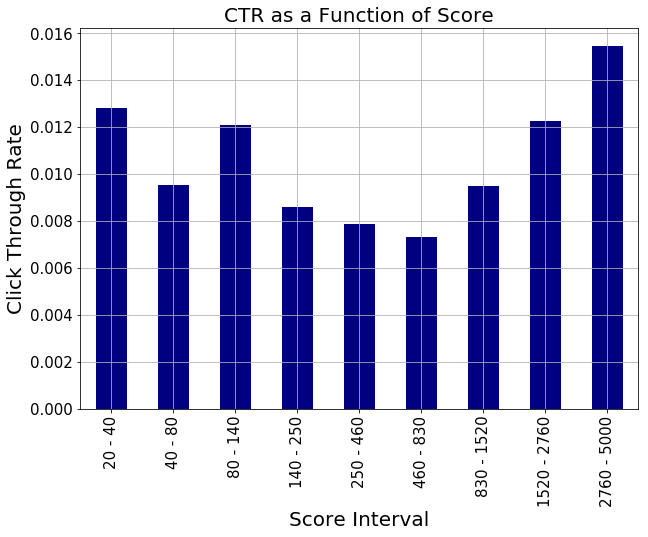

In [159]:
ax = score_CTR[('CTR', 'mean')].plot(figsize = (10, 7),
                                     title = 'CTR as a Function of Score',
                                     colormap = 'jet',
                                    kind = 'bar')
ax.title.set_size(20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_ylabel('Click Through Rate', fontsize = 20)
ax.set_xlabel('Score Interval', fontsize = 20)
xticks = ['0 - 3.45e-11', '3.45e-11 - 1.25e-09', '1.25e-09 - 4.5e-08', '4.5e-08 - 1.63e-06',
          '1.63e-06 - 5.87e-05', '5.87e-05 - 2.12e-03', '2.12e-03 - 0.08', '0.08 - 2.8', '2.8 - 100']
plt.grid()
ax.set_xticklabels(ticks)
plt.savefig('score_v_ctr.png')
plt.show()

In [39]:
train.groupby('score_cat').agg({'total_impressions' : functions + ['sum']})

total_impressions                        \
                                                mean            std  count   
score_cat                                                                    
(-0.0009999999990460001, 3.45e-11]        770.625000    1367.683541      8   
(3.45e-11, 1.25e-09]                      743.480000    1144.513576    150   
(1.25e-09, 4.5e-08]                       481.701094     795.294140    823   
(4.5e-08, 1.63e-06]                      1635.811618   14656.782644   9210   
(1.63e-06, 5.87e-05]                     1516.041951   11499.466669  73229   
(5.87e-05, 0.00212]                      2820.304750   25194.514005  20443   
(0.00212, 0.0766]                        5233.310385   24003.844356  31477   
(0.0766, 2.768]                         24957.714613  101104.082890  20975   
(2.768, 100.0]                         156717.478571  438290.694527   1400   

                                                              
                                         max  min        sum  
score_cat                                                     
(-0.0009999999990460001, 3.45e-11]      4017  110       6165  
(3.45e-11, 1.25e-09]                    7670  102     111522  
(1.25e-09, 4.5e-08]                    14207  100     396440  
(4.5e-08, 1.63e-06]                  1045201  100   15065825  
(1.63e-06, 5.87e-05]                 1049755  100  111018236  
(5.87e-05, 0.00212]                  2729768  100   57655490  
(0.00212, 0.0766]                    1902872  100  164728911  
(0.0766, 2.768]                      5062025  100  523488064  
(2.768, 100.0]                      10518678  100  219404470

In [40]:
train.groupby('score_cat').agg({'total_clicks' : functions + ['sum']})

total_clicks                             \
                                           mean          std  count    max   
score_cat                                                                    
(-0.0009999999990460001, 3.45e-11]     5.125000     6.151365      8     17   
(3.45e-11, 1.25e-09]                   7.113333    23.274994    150    235   
(1.25e-09, 4.5e-08]                    5.230863    19.909287    823    529   
(4.5e-08, 1.63e-06]                   12.941260   177.363036   9210  14425   
(1.63e-06, 5.87e-05]                  11.678611   117.067232  73229   9878   
(5.87e-05, 0.00212]                   21.483980   316.899015  20443  29960   
(0.00212, 0.0766]                     48.335007   429.628897  31477  45684   
(0.0766, 2.768]                      297.579023  1375.627813  20975  60255   
(2.768, 100.0]                      2141.385714  5855.762744   1400  94066   

                                                 
                                   min      sum  
score_cat                                        
(-0.0009999999990460001, 3.45e-11]   1       41  
(3.45e-11, 1.25e-09]                 1     1067  
(1.25e-09, 4.5e-08]                  1     4305  
(4.5e-08, 1.63e-06]                  1   119189  
(1.63e-06, 5.87e-05]                 1   855213  
(5.87e-05, 0.00212]                  1   439197  
(0.00212, 0.0766]                    1  1521441  
(0.0766, 2.768]                      1  6241720  
(2.768, 100.0]                       1  2997940

In [41]:
train.groupby('ctr_cat').agg({'score' : functions})

score                                           
                           mean       std  count         max           min
ctr_cat                                                                   
(-0.000869, 0.000287]  0.000520  0.001174     15    0.004267  5.540995e-06
(0.000287, 0.000628]   0.005836  0.033600    601    0.502631  1.570621e-08
(0.000628, 0.00138]    0.008783  0.104509   4587    4.724907  3.595113e-10
(0.00138, 0.00302]     0.017629  0.145498  20608    6.890761  8.127684e-11
(0.00302, 0.0066]      0.051181  0.375243  51935   23.966449  4.156850e-12
(0.0066, 0.0145]       0.180054  1.128546  55491   61.406490  9.544787e-13
(0.0145, 0.0317]       0.306650  1.696977  21178  100.000000  5.001119e-11
(0.0317, 0.0694]       0.328221  1.648326   3160   41.634112  1.597033e-11
(0.0694, 0.152]        0.303929  0.943986    140    8.261179  5.364413e-09

In [42]:
unit_price_ctr = train.groupby('unitprice_cat').agg({'CTR' : functions})
unit_price_ctr

CTR                                      
                    mean       std   count       max       min
unitprice_cat                                                 
(1.639, 1.998]  0.009995  0.008533   24564  0.114865  0.000252
(1.998, 2.356]  0.008747  0.007868  106833  0.152000  0.000131
(2.356, 2.713]  0.008082  0.007150   20352  0.109091  0.000145
(2.713, 3.071]  0.008365  0.008085    3693  0.109091  0.000333
(3.071, 3.429]  0.007988  0.007536    1415  0.062176  0.000202
(3.429, 3.787]  0.007380  0.006552     506  0.067227  0.000428
(3.787, 4.144]  0.008236  0.007330     307  0.050000  0.000497
(4.144, 4.502]  0.006728  0.004234      43  0.019608  0.000833
(4.502, 4.86]   0.006212  0.002596       2  0.008048  0.004376

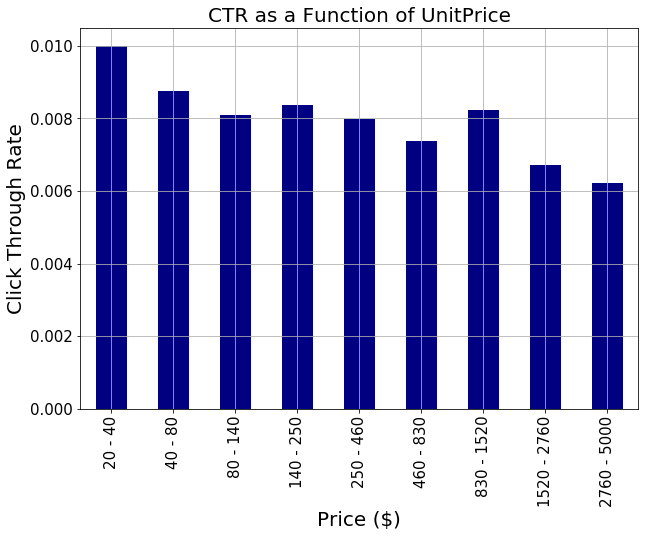

In [158]:
ax = unit_price_ctr[('CTR', 'mean')].plot(figsize = (10, 7),
                                          title = 'CTR as a Function of UnitPrice',
                                          colormap = 'jet',
                                         kind = 'bar')
ax.title.set_size(20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_ylabel('Click Through Rate', fontsize = 20)
ax.set_xlabel('Price ($)', fontsize = 20)
xticks = ['1.60 - 2', '2 - 2.40', '2.40 - 2.70', '2.70 - 3.10', '3.10 - 3.40',
          '3.40 - 3.80', '3.80 - 4.10', '4.10 - 4.50', '4.50 - 4.90']
plt.grid()
ax.set_xticklabels(ticks)
plt.savefig('unitprice_v_ctr.png')
plt.show()

In [44]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, create_feature = True):
        self.feature = create_feature
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X['title_len'] = X['title'].str.len()
        X['descr_len'] = X['description'].str.len()
        X['title_capitals'] = X['title'].str.findall(r'[A-Z]').str.len()
        X['description_capitals'] = X['description'].str.findall(r'[A-Z]').str.len()
        X['title_capital_rate'] = X['title_capitals'] / X['title_len']
        X['descr_capital_rate'] = X['description_capitals'] / X['descr_len']
        
        return X

In [45]:
train['title_len'] = train['title'].str.len()
train['descr_len'] = train['description'].str.len()
train['title_capitals'] = train['title'].str.findall(r'[A-Z]').str.len()
train['description_capitals'] = train['description'].str.findall(r'[A-Z]').str.len()
train['title_capital_rate'] = train['title_capitals'] / train['title_len']
train['descr_capital_rate'] = train['description_capitals'] / train['descr_len']
train.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,...,total_clicks_cat,ctr_cat,score_cat,unitprice_cat,title_len,descr_len,title_capitals,description_capitals,title_capital_rate,descr_capital_rate
id,,,,,,,,,,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,...,"(-0.001, 10000.0]","(0.00302, 0.0066]","(5.87e-05, 0.00212]","(1.639, 1.998]",42,201,6,6,0.142857,0.029851
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,...,"(-0.001, 10000.0]","(0.000628, 0.00138]","(1.63e-06, 5.87e-05]","(1.998, 2.356]",40,428,6,12,0.150000,0.028037
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,...,"(-0.001, 10000.0]","(0.00302, 0.0066]","(5.87e-05, 0.00212]","(1.998, 2.356]",25,318,3,6,0.120000,0.018868
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,...,"(-0.001, 10000.0]","(0.00302, 0.0066]","(1.63e-06, 5.87e-05]","(1.998, 2.356]",43,245,1,6,0.023256,0.024490
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,...,"(-0.001, 10000.0]","(0.00138, 0.00302]","(1.63e-06, 5.87e-05]","(2.356, 2.713]",48,597,1,16,0.020833,0.026801


In [46]:
train[['title_len', 'descr_len', 'title_capitals', 'description_capitals', 'title_capital_rate', 'descr_capital_rate']].describe()

,title_len,descr_len,title_capitals,description_capitals,title_capital_rate,descr_capital_rate
count,157715.000000,157715.000000,157715.000000,157715.000000,157715.000000,157715.000000
mean,50.446058,330.228323,6.417056,14.269765,0.128633,0.048973
std,13.598024,265.401665,2.359540,24.627603,0.037435,0.057427
min,9.000000,23.000000,0.000000,1.000000,0.000000,0.001362
25%,42.000000,151.000000,5.000000,5.000000,0.112903,0.019763
50%,50.000000,268.000000,6.000000,8.000000,0.129870,0.030879
75%,60.000000,440.000000,8.000000,14.000000,0.147059,0.059748
max,108.000000,5015.000000,19.000000,758.000000,0.387755,0.807245


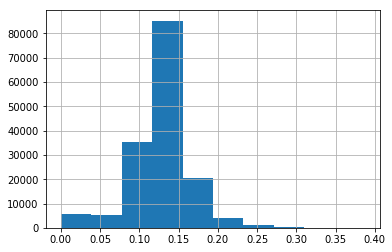

In [47]:
train['title_capital_rate'].hist()

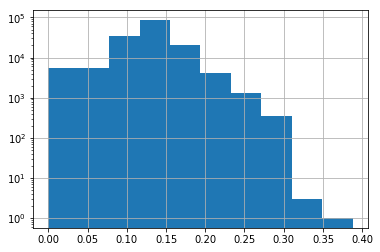

In [48]:
fig, ax = plt.subplots()
train['title_capital_rate'].hist()
ax.set_yscale('log')

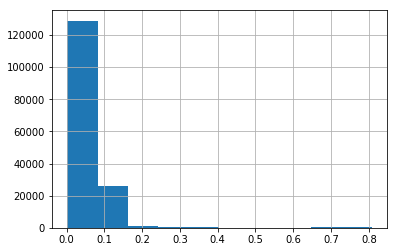

In [49]:
train['descr_capital_rate'].hist()

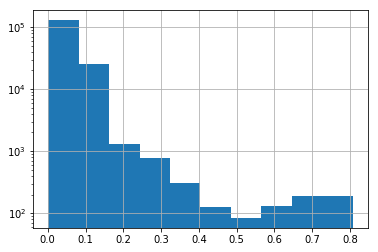

In [50]:
fig, ax = plt.subplots()
train['descr_capital_rate'].hist()
ax.set_yscale('log')

In [51]:
class RateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, perform = True):
        self.perform = perform
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # Bin range for title capital rate
        # Doing some stuff with -inf and +inf because otherwise
        # some results will fall out of scope
        bin_range_tcrc = np.geomspace(1e-2, 0.4, 10)
        bin_range_tcrc[0] = -np.inf 
        bin_range_tcrc[-1] = np.inf
        
        bin_range_dcrc = np.geomspace(0.001362, 0.807245, 10)
        
        X['descr_capital_rate'] = pd.cut(X['descr_capital_rate'], bins = bin_range_dcrc)
        X['title_capital_rate'] = pd.cut(X['title_capital_rate'], bins = bin_range_tcrc)
        
        return X

In [52]:
tcrb = np.linspace(-0.1e-7, 0.4, 10)
tcrb

array([-1.00000000e-08,  4.44444356e-02,  8.88888811e-02,  1.33333327e-01,
        1.77777772e-01,  2.22222218e-01,  2.66666663e-01,  3.11111109e-01,
        3.55555554e-01,  4.00000000e-01])

In [53]:
train['title_cap_rate_cat'] = pd.cut(train['title_capital_rate'], bins = tcrb, include_lowest = True)

In [54]:
train['title_cap_rate_cat'].value_counts(dropna = False)

(0.0889, 0.133]          72064
(0.133, 0.178]           62423
(0.0444, 0.0889]          7076
(0.178, 0.222]            6919
(-0.00100001, 0.0444]     6587
(0.222, 0.267]            2195
(0.267, 0.311]             447
(0.311, 0.356]               3
(0.356, 0.4]                 1
Name: title_cap_rate_cat, dtype: int64

In [55]:
train.groupby('title_cap_rate_cat').agg({'CTR' : functions})

CTR                                     
                           mean       std  count       max       min
title_cap_rate_cat                                                  
(-0.00100001, 0.0444]  0.008462  0.007290   6587  0.100000  0.000315
(0.0444, 0.0889]       0.009175  0.008368   7076  0.081818  0.000202
(0.0889, 0.133]        0.008676  0.007663  72064  0.128713  0.000131
(0.133, 0.178]         0.008974  0.008098  62423  0.152000  0.000231
(0.178, 0.222]         0.009270  0.008609   6919  0.112821  0.000145
(0.222, 0.267]         0.008783  0.008062   2195  0.086207  0.000356
(0.267, 0.311]         0.008378  0.006559    447  0.044156  0.000590
(0.311, 0.356]         0.005717  0.000984      3  0.006818  0.004926
(0.356, 0.4]           0.001645       NaN      1  0.001645  0.001645

In [56]:
bin_range_tcrc = np.geomspace(1e-2, 0.4, 10)
bin_range_tcrc

array([0.01      , 0.0150663 , 0.02269935, 0.03419952, 0.05152603,
       0.07763067, 0.11696071, 0.17621654, 0.26549315, 0.4       ])

In [57]:
bin_range_tcrc[0] = -np.inf
bin_range_tcrc[-1] = np.inf
bin_range_tcrc

array([      -inf, 0.0150663 , 0.02269935, 0.03419952, 0.05152603,
       0.07763067, 0.11696071, 0.17621654, 0.26549315,        inf])

In [58]:
train['title_cap_rate_cat'] = pd.cut(train['title_capital_rate'], bins = bin_range_tcrc)

In [59]:
train['title_cap_rate_cat'].value_counts(dropna = False)

(0.117, 0.176]      100375
(0.0776, 0.117]      36203
(0.176, 0.265]        9717
(0.0342, 0.0515]      3126
(0.0515, 0.0776]      3110
(0.0227, 0.0342]      1757
(0.0151, 0.0227]      1607
(-inf, 0.0151]        1369
(0.265, inf]           451
Name: title_cap_rate_cat, dtype: int64

In [60]:
title_cap_ctr = train.groupby('title_cap_rate_cat').agg({'CTR' : functions})
title_cap_ctr

CTR                                      
                        mean       std   count       max       min
title_cap_rate_cat                                                
(-inf, 0.0151]      0.008040  0.007175    1369  0.100000  0.000344
(0.0151, 0.0227]    0.008109  0.006722    1607  0.063584  0.000315
(0.0227, 0.0342]    0.008942  0.007612    1757  0.075000  0.000595
(0.0342, 0.0515]    0.008839  0.007625    3126  0.085366  0.000403
(0.0515, 0.0776]    0.008926  0.008297    3110  0.081818  0.000221
(0.0776, 0.117]     0.008694  0.007673   36203  0.112150  0.000202
(0.117, 0.176]      0.008869  0.007946  100375  0.152000  0.000131
(0.176, 0.265]      0.009197  0.008603    9717  0.115226  0.000145
(0.265, inf]        0.008345  0.006541     451  0.044156  0.000590

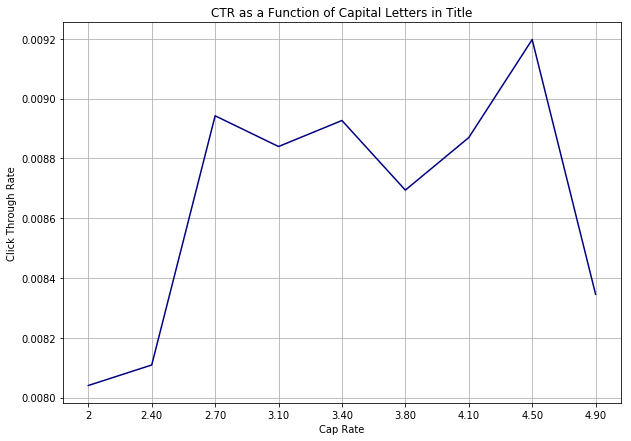

In [61]:
ax = title_cap_ctr[('CTR', 'mean')].plot(figsize = (10, 7), title = 'CTR as a Function of Capital Letters in Title', colormap = 'jet')
ax.set_ylabel('Click Through Rate')
ax.set_xlabel('Cap Rate')
ticks = [0.015, 0.023, 0.034, 0.052, 0.078, 0.12, 0.18, 0.27, 0.4]
plt.grid()
ax.set_xticklabels(xticks)
plt.savefig('CTR_v_title_cap_rate.png')
plt.show()

In [62]:
train.groupby('title_cap_rate_cat').agg({'total_impressions' : functions})

total_impressions                                      
                                mean            std   count       max  min
title_cap_rate_cat                                                        
(-inf, 0.0151]          13359.073776  287774.236801    1369  10518678  100
(0.0151, 0.0227]         4378.770380   25839.270539    1607    541649  100
(0.0227, 0.0342]         5745.563460   48529.956935    1757   1498902  100
(0.0342, 0.0515]         4849.050224   33710.774031    3126    980789  100
(0.0515, 0.0776]         6408.180064   55242.333407    3110   2341954  100
(0.0776, 0.117]          8475.081540   63027.588316   36203   2729768  100
(0.117, 0.176]           6687.146142   52158.921024  100375   5062025  100
(0.176, 0.265]           4350.222291   43350.619508    9717   1902872  100
(0.265, inf]             2329.401330   14553.820158     451    287606  102

In [63]:
train.groupby('title_cap_rate_cat').agg({'total_clicks' : functions})

total_clicks                                
                           mean          std   count    max min
title_cap_rate_cat                                             
(-inf, 0.0151]       123.392988  2584.142240    1369  94066   1
(0.0151, 0.0227]      44.525825   394.738926    1607   9736   1
(0.0227, 0.0342]      57.262379   519.422560    1757  13594   1
(0.0342, 0.0515]      45.912668   368.756921    3126  12134   1
(0.0515, 0.0776]      65.676527   557.468907    3110  19507   1
(0.0776, 0.117]       95.883269   901.340121   36203  60255   1
(0.117, 0.176]        74.158516   741.060107  100375  72414   1
(0.176, 0.265]        58.236904   931.057498    9717  48092   1
(0.265, inf]          23.141907   187.683687     451   3525   1

In [64]:
bin_range_dcrc = np.geomspace(0.001362, 0.807245, 10)
train['descr_cap_rate_cat'] = pd.cut(train['descr_capital_rate'], bins = bin_range_dcrc)

In [65]:
descr_cap_ctr = train.groupby('descr_cap_rate_cat').agg({'CTR' : functions})
descr_cap_ctr

CTR                                     
                        mean       std  count       max       min
descr_cap_rate_cat                                               
(0.00136, 0.00277]  0.007928  0.006583     54  0.036697  0.001014
(0.00277, 0.00563]  0.008641  0.008823    160  0.071749  0.000584
(0.00563, 0.0114]   0.008321  0.007226   5173  0.081967  0.000401
(0.0114, 0.0233]    0.008596  0.007599  49326  0.120301  0.000221
(0.0233, 0.0473]    0.008726  0.007726  52709  0.128713  0.000131
(0.0473, 0.0961]    0.008989  0.007802  30346  0.152000  0.000233
(0.0961, 0.195]     0.009550  0.009225  17600  0.123711  0.000286
(0.195, 0.397]      0.010971  0.010058   1606  0.094444  0.000431
(0.397, 0.807]      0.008052  0.007526    741  0.067227  0.000451

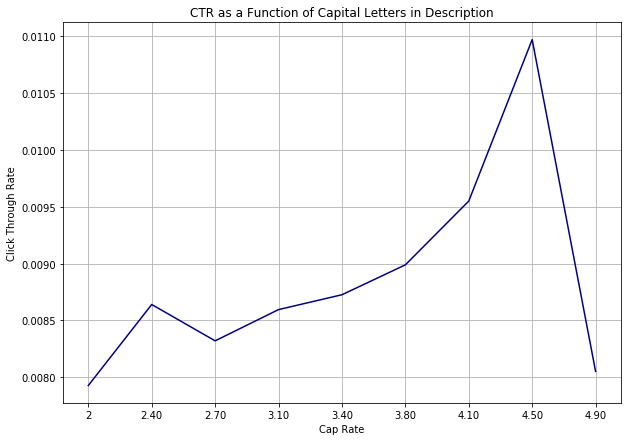

In [66]:
ax = descr_cap_ctr[('CTR', 'mean')].plot(figsize = (10, 7), title = 'CTR as a Function of Capital Letters in Description', colormap = 'jet')
ax.set_ylabel('Click Through Rate')
ax.set_xlabel('Cap Rate')
ticks = [0.0028, 0.0056, 0.011, 0.0233, 0.047, 0.096, 0.2, 0.4, 0.8]
plt.grid()
ax.set_xticklabels(xticks)
plt.savefig('CTR_v_description_cap_rate.png')

In [67]:
train.groupby('descr_cap_rate_cat').agg({'total_clicks' : functions})

total_clicks                              
                           mean         std  count    max min
descr_cap_rate_cat                                           
(0.00136, 0.00277]    48.907407  266.183315     54   1895   1
(0.00277, 0.00563]    15.500000   84.324993    160    888   1
(0.00563, 0.0114]     92.421999  628.800865   5173  17624   1
(0.0114, 0.0233]      73.515164  788.364045  49326  94066   1
(0.0233, 0.0473]      69.412852  744.360673  52709  72414   1
(0.0473, 0.0961]      88.125387  960.302328  30346  61475   1
(0.0961, 0.195]       88.800909  877.014025  17600  44906   1
(0.195, 0.397]        73.063512  621.939895   1606  20744   1
(0.397, 0.807]        77.615385  502.088701    741   8383   1

In [68]:
train.groupby('descr_cap_rate_cat').agg({'total_impressions' : functions})

total_impressions                                    
                                mean           std  count       max  min
descr_cap_rate_cat                                                      
(0.00136, 0.00277]       5414.666667  28112.998855     54    203336  102
(0.00277, 0.00563]       1944.293750   7947.113216    160     73296  101
(0.00563, 0.0114]        8821.653586  49242.886690   5173   1274073  100
(0.0114, 0.0233]         6846.132405  65921.639816  49326  10518678  100
(0.0233, 0.0473]         6212.957142  54941.179305  52709   5062025  100
(0.0473, 0.0961]         7532.754432  61322.278022  30346   2729768  100
(0.0961, 0.195]          7789.994830  60151.838360  17600   2588647  100
(0.195, 0.397]           6189.331880  39129.104249   1606    715152  100
(0.397, 0.807]           6522.541161  29906.609608    741    479269  100

In [69]:
train.groupby('descr_cap_rate_cat').agg({'total_impressions' : functions})

total_impressions                                    
                                mean           std  count       max  min
descr_cap_rate_cat                                                      
(0.00136, 0.00277]       5414.666667  28112.998855     54    203336  102
(0.00277, 0.00563]       1944.293750   7947.113216    160     73296  101
(0.00563, 0.0114]        8821.653586  49242.886690   5173   1274073  100
(0.0114, 0.0233]         6846.132405  65921.639816  49326  10518678  100
(0.0233, 0.0473]         6212.957142  54941.179305  52709   5062025  100
(0.0473, 0.0961]         7532.754432  61322.278022  30346   2729768  100
(0.0961, 0.195]          7789.994830  60151.838360  17600   2588647  100
(0.195, 0.397]           6189.331880  39129.104249   1606    715152  100
(0.397, 0.807]           6522.541161  29906.609608    741    479269  100

# Investigation into Categorical Labels

In [70]:
train['agegroup'].value_counts()

infant     22679
adult       2032
kids        1256
newborn        8
toddler        2
Name: agegroup, dtype: int64

In [71]:
train.loc[train['agegroup'] == 'newborn', 'agegroup'] = 'infant'
train.loc[train['agegroup'] == 'toddler', 'agegroup'] = 'infant'
train['agegroup'].value_counts()

infant    22689
adult      2032
kids       1256
Name: agegroup, dtype: int64

In [72]:
train['agegroup'].value_counts(dropna = False)

NaN       131738
infant     22689
adult       2032
kids        1256
Name: agegroup, dtype: int64

In [73]:
train.groupby('agegroup').agg({'CTR' : functions})

CTR                                     
              mean       std  count       max       min
agegroup                                               
adult     0.008920  0.008299   2032  0.120301  0.000410
infant    0.009019  0.007665  22689  0.100529  0.000283
kids      0.007694  0.006733   1256  0.054987  0.000274

In [74]:
train['material'].value_counts()

lace                  3331
linen                  159
satin                  143
denim                  133
silk                   115
leather                 63
lace/linen              44
velvet                  44
jersey                  41
cotton                  29
denim/lace              22
flannel                 21
lace/leather            17
canvas                  16
lace/silk               14
straw                   11
chiffon                 10
lace/satin               9
canvas/linen             9
fur                      8
denim/leather            4
seersucker               4
crochet/lace             3
satin/silk               2
canvas/lace              2
tweed                    2
suede                    2
denim/lace/leather       2
linen/seersucker         1
silk/suede               1
wool                     1
acrylic                  1
crochet                  1
linen/silk               1
knit                     1
lace/velvet              1
Name: material, dtype: int64

In [75]:
train.groupby('material').agg({'CTR' : functions}).sort_values([('CTR', 'mean')], ascending = False)

CTR                                    
                        mean       std count       max       min
material                                                        
tweed               0.015875  0.008861     2  0.022140  0.009609
wool                0.013453       NaN     1  0.013453  0.013453
flannel             0.013026  0.008855    21  0.044248  0.002320
denim/lace          0.010814  0.005762    22  0.027972  0.002933
lace/leather        0.010677  0.008380    17  0.035088  0.001319
cotton              0.010534  0.013855    29  0.071006  0.001416
linen/seersucker    0.009531       NaN     1  0.009531  0.009531
velvet              0.009363  0.006602    44  0.025424  0.000829
chiffon             0.009153  0.007849    10  0.024087  0.003546
satin               0.008835  0.006680   143  0.045113  0.000908
denim               0.008719  0.006212   133  0.039683  0.000714
jersey              0.008512  0.007162    41  0.039216  0.001556
knit                0.008197       NaN     1  0.008197  0.008197
lace                0.008096  0.006898  3331  0.077320  0.000293
lace/satin          0.008079  0.003137     9  0.013793  0.003927
crochet/lace        0.007883  0.002364     3  0.010309  0.005587
lace/silk           0.007698  0.010131    14  0.040650  0.001572
silk                0.007624  0.006764   115  0.051813  0.000572
canvas              0.007495  0.004188    16  0.016529  0.001616
fur                 0.007207  0.004189     8  0.016129  0.002183
denim/lace/leather  0.006999  0.001055     2  0.007745  0.006252
canvas/linen        0.006977  0.008834     9  0.028736  0.001115
leather             0.006791  0.005037    63  0.022222  0.001057
linen               0.006762  0.007136   159  0.060870  0.000695
satin/silk          0.006640  0.004676     2  0.009946  0.003333
crochet             0.005319       NaN     1  0.005319  0.005319
lace/linen          0.005218  0.004022    44  0.026362  0.001079
denim/leather       0.004987  0.001699     4  0.006553  0.002632
lace/velvet         0.004658       NaN     1  0.004658  0.004658
suede               0.004366  0.002616     2  0.006216  0.002517
linen/silk          0.004310       NaN     1  0.004310  0.004310
straw               0.004262  0.002678    11  0.008511  0.001379
acrylic             0.004132       NaN     1  0.004132  0.004132
seersucker          0.003679  0.001141     4  0.004723  0.002336
canvas/lace         0.003381  0.000292     2  0.003587  0.003175
silk/suede          0.003215       NaN     1  0.003215  0.003215

In [76]:
train.loc[train['material'] != 'lace', 'material'] = 'other'
train.groupby('material').agg({'CTR' : functions}).sort_values([('CTR', 'mean')], ascending = False)

CTR                                     
              mean       std   count      max       min
material                                               
other     0.008850  0.007923  154384  0.15200  0.000131
lace      0.008096  0.006898    3331  0.07732  0.000293

In [77]:
train.groupby('pattern').agg({'CTR' : functions}).sort_values([('CTR', 'count')], ascending = False)

CTR                                    
                                   mean       std count       max       min
pattern                                                                    
floral                         0.009385  0.008083  7856  0.152000  0.000306
chevron                        0.008440  0.006894  1113  0.059829  0.000556
zebra                          0.006746  0.005504  1099  0.050420  0.000274
leopard                        0.007556  0.005884   587  0.043478  0.000816
stripe                         0.008293  0.006559   562  0.071174  0.000973
polka dot                      0.008120  0.007044   516  0.059880  0.000547
polka dots                     0.007188  0.005490   379  0.040323  0.000561
camo                           0.008013  0.007258   332  0.059041  0.000225
gingham                        0.009867  0.008084   327  0.055556  0.000669
plaid                          0.009283  0.006967   247  0.040956  0.000506
tartan                         0.008374  0.006211   238  0.034014  0.000596
striped                        0.008964  0.010492   207  0.120301  0.000615
paisley                        0.007592  0.009247   198  0.070528  0.000803
plaid/tartan                   0.006459  0.004565   186  0.039474  0.000706
cheetah                        0.014209  0.014253   173  0.084158  0.000825
metallic                       0.007424  0.005742   158  0.035461  0.000894
leopard/leopard print          0.007396  0.006013   138  0.044872  0.000740
tiger                          0.009127  0.007051    86  0.043139  0.000604
camouflage                     0.009246  0.006410    69  0.038462  0.000701
check                          0.007655  0.005613    58  0.022727  0.000635
argyle                         0.008236  0.006901    53  0.037037  0.000632
graphic                        0.006910  0.005106    46  0.023551  0.001036
animal print                   0.005930  0.005101    43  0.025806  0.000829
camo/camouflage                0.008092  0.005490    40  0.030151  0.001706
leopard/zebra                  0.007494  0.008121    39  0.042394  0.000607
spot                           0.006728  0.004461    37  0.019950  0.001092
floral/stripe                  0.009108  0.007482    33  0.040936  0.002395
pinstripe                      0.006957  0.005562    30  0.025862  0.000745
houndstooth                    0.008034  0.006347    28  0.027888  0.001521
checkered                      0.007541  0.005189    27  0.019231  0.000720
...                                 ...       ...   ...       ...       ...
animal print/cheetah           0.007774  0.003815     2  0.010471  0.005076
chevron/striped                0.005518  0.001462     2  0.006552  0.004484
checkered/gingham              0.006915  0.003438     2  0.009346  0.004484
snake print                    0.003891       NaN     1  0.003891  0.003891
floral/plaid                   0.004132       NaN     1  0.004132  0.004132
checkered/gingham/plaid        0.003650       NaN     1  0.003650  0.003650
chevron/paisley                0.006457       NaN     1  0.006457  0.006457
animal print/cheetah/zebra     0.002424       NaN     1  0.002424  0.002424
tiger/zebra                    0.002299       NaN     1  0.002299  0.002299
tropical print                 0.007752       NaN     1  0.007752  0.007752
stripe/tiger                   0.011696       NaN     1  0.011696  0.011696
argyle/chevron                 0.003230       NaN     1  0.003230  0.003230
animal print/leopard/zebra     0.010156       NaN     1  0.010156  0.010156
polka dot/spot                 0.003348       NaN     1  0.003348  0.003348
floral/graphic                 0.002364       NaN     1  0.002364  0.002364
floral/spot                    0.004016       NaN     1  0.004016  0.004016
floral/zebra                   0.013699       NaN     1  0.013699  0.013699
gingham/stripe                 0.006579       NaN     1  0.006579  0.006579
camouflage/printed             0.003883       NaN     1  0.003883  0.003883
graphic/

In [78]:
train.loc[train['pattern'] != 'floral', 'pattern'] = 'other'
train.groupby('pattern').agg({'CTR' : functions}).sort_values([('CTR', 'count')], ascending = False)

CTR                                      
             mean       std   count       max       min
pattern                                                
other    0.008805  0.007893  149859  0.128713  0.000131
floral   0.009385  0.008083    7856  0.152000  0.000306

In [79]:
train['label'].value_counts(dropna = False)

sold_locally     78839
other            69811
sold_globally     6180
merchandised      2885
Name: label, dtype: int64

In [80]:
train.groupby('label').agg({'CTR' : functions})

CTR                                     
                   mean       std  count       max       min
label                                                       
merchandised   0.008424  0.007072   2885  0.068579  0.000326
other          0.008424  0.007596  69811  0.123932  0.000131
sold_globally  0.008528  0.007742   6180  0.120690  0.000252
sold_locally   0.009236  0.008186  78839  0.152000  0.000145

# Capital Letters

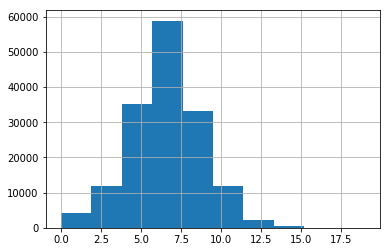

In [81]:
train['title_capitals'].hist()

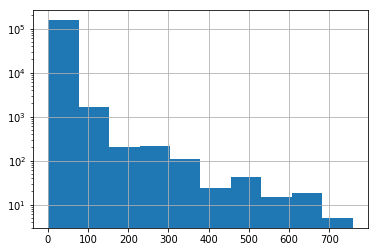

In [82]:
fig, ax = plt.subplots()
train['description_capitals'].hist()
ax.set_yscale('log')

In [83]:
class CapitalCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self, perform = True):
        self.perform = perform
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        bin_span_dcc = np.geomspace(1, 760, 10)
        
        X['title_capitals'] = pd.cut(X['title_capitals'], bins = 10)
        X['description_capitals'] = pd.cut(X['description_capitals'], bins = bin_span_dcc, include_lowest = True)
        return X

In [84]:
train['title_capitals_cat'] = pd.cut(train['title_capitals'], bins = 10)
bin_span_dcc = np.geomspace(1, 760, 10)
train['description_capitals_cat'] = pd.cut(train['description_capitals'], bins = bin_span_dcc, include_lowest = True)

In [85]:
train['description_capitals_cat'].value_counts(dropna = False)

(4.367, 9.126]        56504
(9.126, 19.07]        41344
(2.09, 4.367]         25270
(19.07, 39.852]       14097
(39.852, 83.28]        9501
(0.999, 2.09]          9030
(83.28, 174.033]       1416
(174.033, 363.683]      446
(363.683, 760.0]        107
Name: description_capitals_cat, dtype: int64

In [86]:
train.groupby('title_capitals_cat').agg({'CTR' : functions})

CTR                                     
                        mean       std  count       max       min
title_capitals_cat                                               
(-0.019, 1.9]       0.008167  0.007114   4303  0.100000  0.000315
(1.9, 3.8]          0.008841  0.007970  11802  0.128713  0.000304
(3.8, 5.7]          0.009217  0.008683  35117  0.123711  0.000145
(5.7, 7.6]          0.008695  0.007714  58842  0.152000  0.000131
(7.6, 9.5]          0.008778  0.007644  33121  0.120301  0.000283
(9.5, 11.4]         0.008819  0.007389  11903  0.085859  0.000274
(11.4, 13.3]        0.008706  0.007570   2153  0.086207  0.000331
(13.3, 15.2]        0.008377  0.006110    395  0.044156  0.000736
(15.2, 17.1]        0.009217  0.006695     71  0.027523  0.000936
(17.1, 19.0]        0.007193  0.006242      8  0.017751  0.000586

In [87]:
train.groupby('description_capitals_cat').agg({'CTR' : functions})

CTR                                     
                              mean       std  count       max       min
description_capitals_cat                                               
(0.999, 2.09]             0.009529  0.008761   9030  0.128713  0.000145
(2.09, 4.367]             0.009726  0.008981  25270  0.123932  0.000221
(4.367, 9.126]            0.009069  0.007981  56504  0.152000  0.000131
(9.126, 19.07]            0.008431  0.007387  41344  0.115226  0.000225
(19.07, 39.852]           0.008218  0.007450  14097  0.114865  0.000309
(39.852, 83.28]           0.007544  0.006056   9501  0.091954  0.000274
(83.28, 174.033]          0.006901  0.006241   1416  0.062937  0.000300
(174.033, 363.683]        0.005671  0.005022    446  0.038961  0.000540
(363.683, 760.0]          0.005718  0.003518    107  0.016129  0.001033

In [88]:
train.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,...,title_len,descr_len,title_capitals,description_capitals,title_capital_rate,descr_capital_rate,title_cap_rate_cat,descr_cap_rate_cat,title_capitals_cat,description_capitals_cat
id,,,,,,,,,,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,other,other,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,...,42,201,6,6,0.142857,0.029851,"(0.117, 0.176]","(0.0233, 0.0473]","(5.7, 7.6]","(4.367, 9.126]"
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,other,other,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,...,40,428,6,12,0.150000,0.028037,"(0.117, 0.176]","(0.0233, 0.0473]","(5.7, 7.6]","(9.126, 19.07]"
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,other,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,...,25,318,3,6,0.120000,0.018868,"(0.117, 0.176]","(0.0114, 0.0233]","(1.9, 3.8]","(4.367, 9.126]"
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,other,other,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,...,43,245,1,6,0.023256,0.024490,"(0.0227, 0.0342]","(0.0233, 0.0473]","(-0.019, 1.9]","(4.367, 9.126]"
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,other,other,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,...,48,597,1,16,0.020833,0.026801,"(0.0151, 0.0227]","(0.0233, 0.0473]","(-0.019, 1.9]","(9.126, 19.07]"


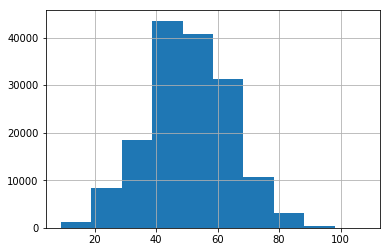

In [89]:
train['title_len'].hist()

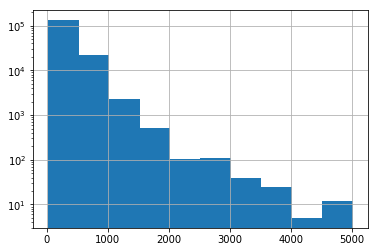

In [90]:
fig, ax = plt.subplots()
train['descr_len'].hist()
ax.set_yscale('log')

In [91]:
train['title_len_cat'] = pd.cut(train['title_len'], bins = 10)
bin_descr_span = np.geomspace(23, 5015, 10)
train['descr_len_cat'] = pd.cut(train['descr_len'], bins = bin_descr_span)

In [92]:
len_ctr = train.groupby('title_len_cat').agg({'CTR' : functions})
len_ctr

CTR                                     
                   mean       std  count       max       min
title_len_cat                                               
(8.901, 18.9]  0.008814  0.009404   1203  0.128713  0.000444
(18.9, 28.8]   0.010018  0.010140   8417  0.123711  0.000145
(28.8, 38.7]   0.008915  0.008128  18565  0.093333  0.000231
(38.7, 48.6]   0.008783  0.007960  43547  0.152000  0.000131
(48.6, 58.5]   0.008768  0.007697  40685  0.123932  0.000225
(58.5, 68.4]   0.008688  0.007495  31240  0.120301  0.000221
(68.4, 78.3]   0.008746  0.007277  10613  0.085859  0.000371
(78.3, 88.2]   0.008575  0.006818   3034  0.085714  0.000274
(88.2, 98.1]   0.008347  0.005501    385  0.036011  0.000404
(98.1, 108.0]  0.008010  0.005828     26  0.027523  0.001468

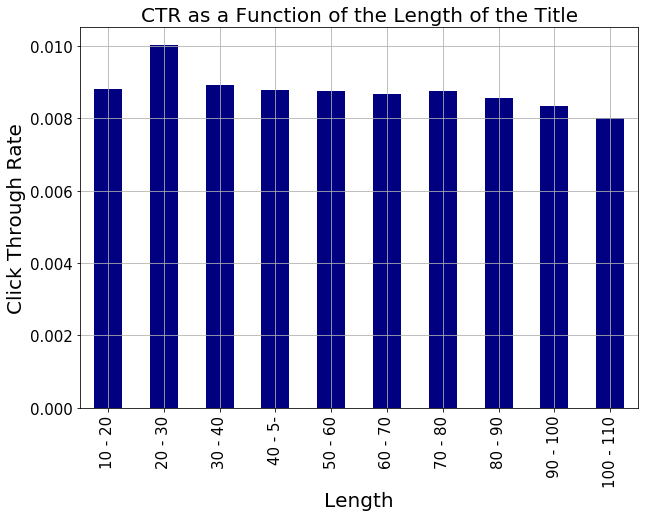

In [93]:
ax = len_ctr[('CTR', 'mean')].plot(figsize = (10, 7),
                                   title = 'CTR as a Function of the Length of the Title',
                                   colormap = 'jet',
                                   kind = 'bar')
ax.title.set_size(20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_ylabel('Click Through Rate', fontsize = 20)
ax.set_xlabel('Length', fontsize = 20)
ticks = ['10 - 20', '20 - 30', '30 - 40', '40 - 5-', '50 - 60',
         '60 - 70', '70 - 80', '80 - 90', '90 - 100', '100 - 110']
plt.grid()
ax.set_xticklabels(ticks)
plt.savefig('CTR_v_title_len.png')

In [94]:
descr_len = train.groupby('descr_len_cat').agg({'CTR' : functions})
descr_len

CTR                                     
                          mean       std  count       max       min
descr_len_cat                                                      
(23.0, 41.838]        0.015447  0.015073   1684  0.123711  0.000344
(41.838, 76.103]      0.009713  0.008890   9465  0.088372  0.000145
(76.103, 138.434]     0.010037  0.009023  23575  0.152000  0.000252
(138.434, 251.814]    0.009188  0.008032  39212  0.117647  0.000233
(251.814, 458.056]    0.008589  0.007370  47579  0.120301  0.000131
(458.056, 833.214]    0.007658  0.006558  28870  0.115226  0.000231
(833.214, 1515.635]   0.006774  0.005926   6522  0.070968  0.000297
(1515.635, 2756.975]  0.005826  0.004887    697  0.038835  0.000381
(2756.975, 5015.0]    0.003925  0.002841    111  0.016760  0.000442

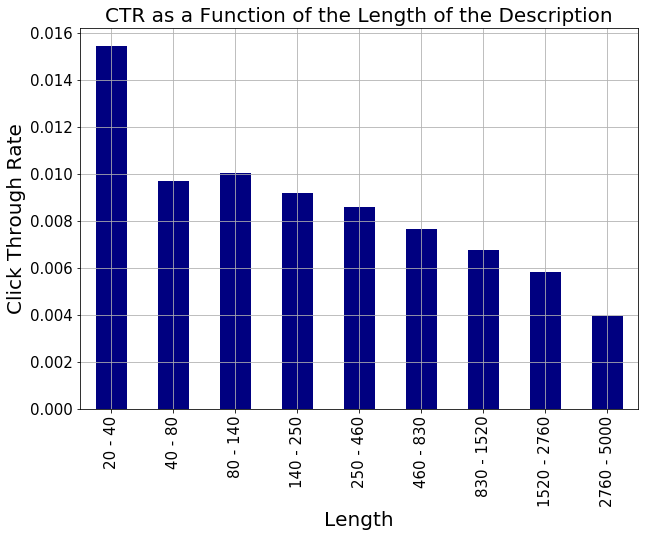

In [95]:
ax = descr_len[('CTR', 'mean')].plot(figsize = (10, 7),
                                     title = 'CTR as a Function of the Length of the Description',
                                     colormap = 'jet',
                                     kind = 'bar')
ax.title.set_size(20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_ylabel('Click Through Rate', fontsize = 20)
ax.set_xlabel('Length', fontsize = 20)
ticks = ['20 - 40', '40 - 80', '80 - 140', '140 - 250', '250 - 460', '460 - 830',
         '830 - 1520', '1520 - 2760', '2760 - 5000']
plt.grid()
ax.set_xticklabels(ticks)
plt.savefig('CTR_v_description_len.png')

In [96]:
class LabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, perform = True):
        self.perform = perform
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X['agegroup'].replace(np.nan, 'nothing', regex = True, inplace = True)
        X.loc[X['material'] != 'lace', 'material'] = 'other'
        X.loc[X['pattern'] != 'floral', 'pattern'] = 'other'
        return X

In [97]:
train['agegroup'].replace(np.nan, 'nothing', regex = True, inplace = True)
train['agegroup'].value_counts(dropna = False)

nothing    131738
infant      22689
adult        2032
kids         1256
Name: agegroup, dtype: int64

In [98]:
train['description_capitals_cat'].value_counts(dropna = False)

(4.367, 9.126]        56504
(9.126, 19.07]        41344
(2.09, 4.367]         25270
(19.07, 39.852]       14097
(39.852, 83.28]        9501
(0.999, 2.09]          9030
(83.28, 174.033]       1416
(174.033, 363.683]      446
(363.683, 760.0]        107
Name: description_capitals_cat, dtype: int64

In [99]:
train = copy.copy()

# Assign X and y

In [100]:
X = train.drop(['CTR', 'total_clicks'], axis = 1)
y = train['total_clicks']
X.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions
id,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514


In [101]:
X.columns, X.shape

(Index(['title', 'description', 'unitprice', 'agegroup', 'material', 'pattern',
        'label', 'imagelink', 'score', 'total_impressions'],
       dtype='object'), (157715, 10))

# Full Pipeline

In [102]:
# scaler = StandardScaler()
# continuous = ['unitprice', 'score', 'total_impressions', 'title_len',
#               'descr_len', 'title_capitals', 'description_capitals',
#              'title_capital_rate', 'descr_capital_rate']
# scaler.fit(X[continuous])

In [103]:
class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, perform = True):
        self.perform = perform
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        labels = ['score',
          'material', 'pattern', 'label', 'unitprice',
         'title_capitals', 'description_capitals', 'title_len', 'descr_len', 'agegroup',
                 'title_capital_rate', 'descr_capital_rate']
        
        X[labels] = X[labels].apply(LabelEncoder().fit_transform)
        return X

In [104]:
class Drop(BaseEstimator, TransformerMixin):
    def __init__(self, perform = True, drop = ['title', 'description', 'imagelink']):
        self.perform = perform
        self.drop = drop
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X.drop(self.drop, inplace = True, axis = 1)
            
        return X
            

In [105]:
pipeline = Pipeline([('score', ScoreFix()),
                     ('trans', Transformer()),
                     ('text', TextTransformer()),
                     ('rate', RateTransformer()),
                     ('cap_cat', CapitalCategorizer()),
                     ('age', LabelTransformer()),
                     ('label', LabelEncoderWrapper()),
                     ('drop', Drop())])

X = pipeline.transform(X)
X.head()

,unitprice,agegroup,material,pattern,label,score,total_impressions,title_len,descr_len,title_capitals,description_capitals,title_capital_rate,descr_capital_rate
id,,,,,,,,,,,,,
161928552431970573,0,1,1,1,3,5,256,33,172,3,2,6,4
161875812970168400,1,4,1,1,1,4,1024,31,399,3,3,6,4
161510361575461736,1,4,1,0,3,5,257,16,289,1,2,6,3
161788880710081190,1,4,1,1,3,4,258,34,216,0,2,2,4
256356471493992743,2,4,1,1,1,4,514,39,568,0,3,1,4


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [107]:
print(len(X_train))
print(len(X_test))

126172
31543


In [108]:
X.columns

Index(['unitprice', 'agegroup', 'material', 'pattern', 'label', 'score',
       'total_impressions', 'title_len', 'descr_len', 'title_capitals',
       'description_capitals', 'title_capital_rate', 'descr_capital_rate'],
      dtype='object')

# Model Creation

In [109]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)

print(f'Linear Regression Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'Linear Regression r2 score: {metrics.r2_score(y_test, y_pred):.2f}')

Linear Regression Mean Squared Error: 88988.12
Linear Regression r2 score: 0.81


In [110]:
y_pred = tree_reg.predict(X_test)
tree_mse = metrics.mean_squared_error(y_test, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

298.3087644916148

In [111]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print(f'Linear Regression Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'Linear Regression Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'Linear Regression r2 score: {metrics.r2_score(y_test, y_pred):.2f}')

Linear Regression Mean Squared Error: 67472.14
Linear Regression Mean Absolute Error: 33.64
Linear Regression r2 score: 0.85


In [112]:
y_test_pred = linreg.predict(X_train)

print(f'Linear Regression Mean Squared Error: {metrics.mean_squared_error(y_train, y_test_pred):.2f}')
print(f'Linear Regression r2 score: {metrics.r2_score(y_train, y_test_pred):.2f}')

Linear Regression Mean Squared Error: 119782.13
Linear Regression r2 score: 0.83


In [113]:
parameters = {'fit_intercept' : [True, False],
             'normalize' : [True, False]}

linreg = LinearRegression()
clf = GridSearchCV(linreg, parameters)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'{clf.best_params_}')

print(f'Logistic Regression Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'Logistic r2 score: {metrics.r2_score(y_test, y_pred):.2f}')
print(f'Logistic explained variance: {metrics.explained_variance_score(y_test, y_pred):.2f}')
print(f'Logistic Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')

{'fit_intercept': False, 'normalize': True}
Logistic Regression Mean Absolute Error: 33.19
Logistic r2 score: 0.85
Logistic explained variance: 0.85
Logistic Mean Squared Error: 67446.87


In [114]:
best_so_far = clf
best_so_far

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
linreg = LinearRegression()

from sklearn.ensemble import AdaBoostRegressor

clf = AdaBoostRegressor(base_estimator = LinearRegression())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'LinearSVR Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'LinearSVR r2 score: {metrics.r2_score(y_test, y_pred):.2f}')
print(f'LinearSVR explained variance: {metrics.explained_variance_score(y_test, y_pred):.2f}')
print(f'LinearSVR Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')

LinearSVR Mean Absolute Error: 1340.56
LinearSVR r2 score: -5.58
LinearSVR explained variance: -4.93
LinearSVR Mean Squared Error: 3015584.19


In [116]:
ran_for = RandomForestRegressor(n_estimators = 1000, min_samples_split = 10,
                                max_features = 0.3, random_state = 0 ,
                                max_depth = 10, n_jobs = -1)

ran_for.fit(X_train, y_train)
y_pred = ran_for.predict(X_test)

In [117]:
print(f'Random Forest Regression Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'Random Forest r2 score: {metrics.r2_score(y_test, y_pred):.2f}')
print(f'Random Forest explained variance: {metrics.explained_variance_score(y_test, y_pred):.2f}')
print(f'Random Forest Regression Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred):.2f}')

Random Forest Regression Mean Squared Error: 84947.22
Random Forest r2 score: 0.81
Random Forest explained variance: 0.81
Random Forest Regression Mean Absolute Error: 45.47


In [118]:
# parameters = {'n_estimators' : np.arange(1, 1000, 200),
#              'max_depth' : np.arange(10, 100, 20),
#              'min_samples_leaf' : [1, 3, 5, 10],
#              'random_state' : np.array([7]),
#              'n_jobs' : np.array([-1])}
# ran_for = RandomForestRegressor()

# clf = GridSearchCV(ran_for, parameters)
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# print(clf.best_score_)

print(f'Random Forest Regression Mean Absolute Error: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'Random Forest r2 score: {metrics.r2_score(y_test, y_pred):.2f}')
print(f'Random Forest explained variance: {metrics.explained_variance_score(y_test, y_pred):.2f}')

Random Forest Regression Mean Absolute Error: 84947.22
Random Forest r2 score: 0.81
Random Forest explained variance: 0.81


# Answer the Test Data

In [119]:
test.head()

,total_impressions,total_clicks,title,description,unitprice,agegroup,material,pattern,label,imagelink,score
id,,,,,,,,,,,
161470442074827593,515,0,Happy 80th Birthday Party Invitation,Perfect for Male or Female ...All Ages availab...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/happy_80th_birthday_par...,0.000009
161245544788419281,260,0,Wisteria Purple Flowers and Fence Wedding Card,This wedding invitation features a photograph ...,3.10,NaN,NaN,NaN,other,https://rlv.zcache.com/wisteria_purple_flowers...,0.000001
256450282188607023,774,0,Blue white modern fashion tie dye striped patt...,Blue white modern fashion tie dye striped patt...,2.01,NaN,NaN,striped,sold_locally,https://rlv.zcache.com/blue_white_modern_fashi...,NaN
161892573295168874,280,0,Rustic Country Barn Wood Wedding Invitations,A rustic country barn wood wedding invitation ...,2.16,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/rustic_country_barn_woo...,0.000063
161123552659461969,283,0,lace pink rose & burlap rehearsal dinner invit...,Beautiful classic rehearsal dinner invitations...,2.26,NaN,lace,NaN,sold_locally,https://rlv.zcache.com/lace_pink_rose_burlap_r...,0.000396


In [120]:
test.drop('total_clicks', axis = 1, inplace = True)
impressions = test['total_impressions']

In [121]:
X = pipeline.transform(test)
X.head()

,total_impressions,unitprice,agegroup,material,pattern,label,score,title_len,descr_len,title_capitals,description_capitals,title_capital_rate,descr_capital_rate
id,,,,,,,,,,,,,
161470442074827593,515,1,3,1,1,3,4,26,35,2,2,5,5
161245544788419281,260,4,3,1,1,1,3,36,154,3,1,6,3
256450282188607023,774,1,3,1,1,3,4,56,54,1,1,2,4
161892573295168874,280,1,3,1,1,3,5,34,312,3,2,6,3
161123552659461969,283,1,3,0,1,3,5,49,495,0,2,0,3


In [122]:
X.columns

Index(['total_impressions', 'unitprice', 'agegroup', 'material', 'pattern',
       'label', 'score', 'title_len', 'descr_len', 'title_capitals',
       'description_capitals', 'title_capital_rate', 'descr_capital_rate'],
      dtype='object')

In [123]:
test['total_clicks'] = best_so_far.predict(X)

In [124]:
original = test_df.copy()

In [125]:
original.drop('total_clicks', inplace = True, axis = 1)
original['total_clicks'] = test['total_clicks']

In [126]:
original.to_csv('../data/results.csv')

## Text Data

In [127]:
from sklearn.decomposition           import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline                import Pipeline
from sklearn.preprocessing           import Normalizer

from sklearn.cluster                 import KMeans
from sklearn                         import metrics

In [128]:
text_data = train[['title', 'description']]
text_data.head()

,title,description
id,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an..."


In [129]:
k = 5

vectorizer = TfidfVectorizer(max_features = 100000,
                             stop_words = 'english',
                             use_idf = True)
svd        = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy = False)

km         = KMeans(n_clusters = k, init = 'k-means++',
                    max_iter = 100, n_init = 10)

pipeline   = Pipeline([('vector', vectorizer),
                       ('svd', svd),
                       ('normalizer', normalizer)])

X = pipeline.fit_transform(text_data['description'])
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [130]:
silhouette = metrics.silhouette_score(X, km.labels_, sample_size = 10000)

print(f'Silhouette Coefficient: {silhouette}')

Silhouette Coefficient: 0.05521396859658066


In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
centers = km.cluster_centers_
reduced = pca.fit_transform(centers)

In [132]:
centers

array([[ 3.93038735e-01, -1.23555269e-01, -1.56899779e-02,
         3.37004560e-01,  3.59255002e-02,  1.51268148e-02,
         3.34435352e-02, -2.19167145e-02,  1.99348429e-02,
         4.37154947e-03, -1.60058890e-02, -2.16110316e-02,
        -2.88319324e-02, -3.66966317e-02,  5.76942976e-03,
         1.64994900e-02, -4.27124121e-03, -2.35487018e-02,
        -3.11140967e-02, -1.41479111e-02, -1.04872370e-02,
        -2.36062694e-05,  1.68051693e-02,  1.19421992e-02,
        -1.99843658e-02, -1.45203070e-02, -2.65715931e-02,
         1.60233896e-02, -1.08812346e-02, -6.71457879e-03,
        -8.54311188e-04,  1.40600671e-02, -4.83722612e-03,
        -9.94174281e-03,  5.42511476e-04,  1.66641298e-02,
        -1.50756243e-02, -1.13848029e-02, -2.00184266e-02,
         4.71553266e-03, -1.26881063e-02,  1.00019586e-03,
        -1.07354634e-02, -9.78060830e-03, -1.28799714e-02,
         2.38403709e-04,  4.70515711e-03, -7.72247295e-03,
         1.06206028e-02,  3.86034697e-03, -1.29276720e-0

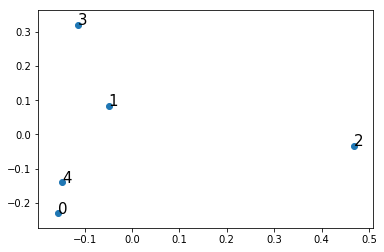

In [133]:
fig, ax = plt.subplots()
ax.scatter(reduced[:, 0], reduced[:, 1])

labels = np.arange(0, k).tolist()

for i, txt in enumerate(labels):
    ax.annotate(txt, (reduced[i, 0], reduced[i, 1]), size = 15)

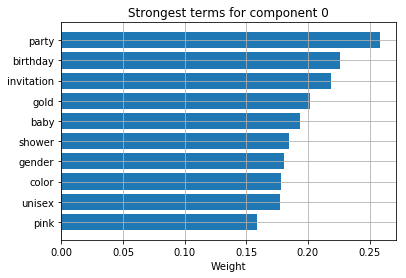

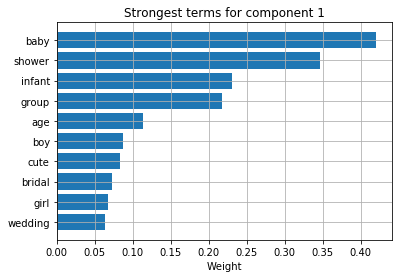

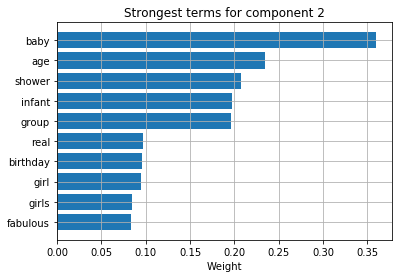

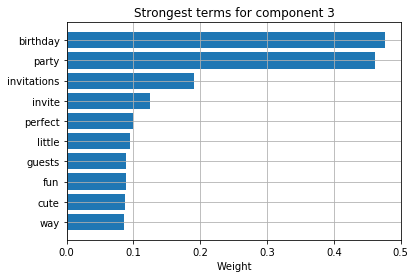

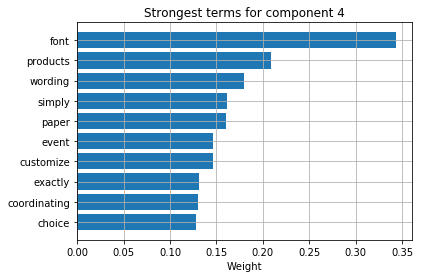

In [134]:
feature_names = vectorizer.get_feature_names()

for i in range(0, k):
    comp = svd.components_[i]
    indeces = np.argsort(comp).tolist()
    indeces.reverse()

    terms = [feature_names[weight] for weight in indeces[0:10]]
    weights = [comp[weight] for weight in indeces[0:10]]

    
    terms.reverse()
    weights.reverse()

    
    positions = np.arange(10) + 0.5
    
    plt.figure(i)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (i))
    plt.grid(True)
    plt.show()

Silhouette Coefficient: 0.08210215483208486


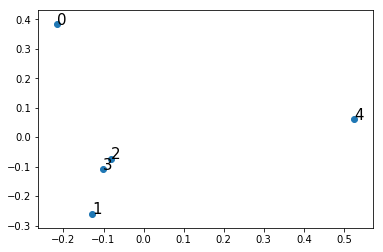

In [135]:
X = pipeline.fit_transform(text_data['title'])
km.fit(X)

silhouette = metrics.silhouette_score(X, km.labels_, sample_size = 10000)
print(f'Silhouette Coefficient: {silhouette}')

pca = PCA(n_components = 2)
centers = km.cluster_centers_
reduced = pca.fit_transform(centers)

fig, ax = plt.subplots()
ax.scatter(reduced[:, 0], reduced[:, 1])

labels = np.arange(0, k).tolist()

for i, txt in enumerate(labels):
    ax.annotate(txt, (reduced[i, 0], reduced[i, 1]), size = 15)

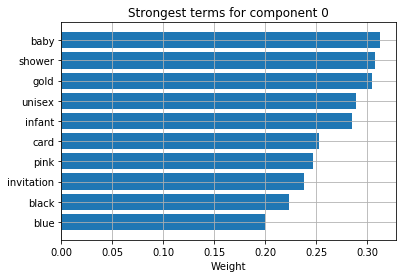

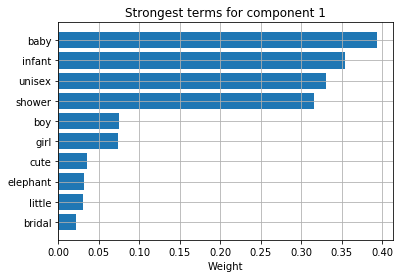

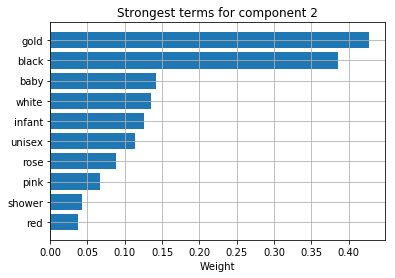

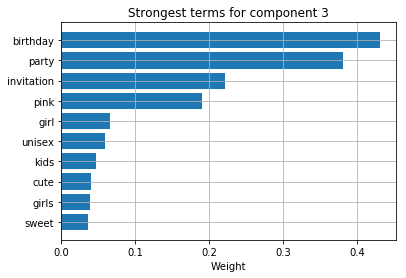

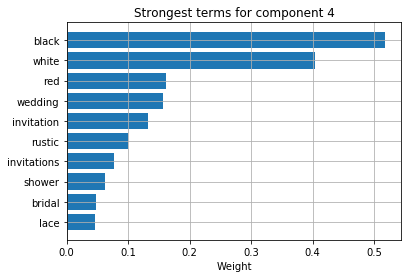

In [136]:
feature_names = vectorizer.get_feature_names()

for i in range(0, k):
    comp = svd.components_[i]
    indeces = np.argsort(comp).tolist()
    indeces.reverse()

    terms = [feature_names[weight] for weight in indeces[0:10]]
    weights = [comp[weight] for weight in indeces[0:10]]

    
    terms.reverse()
    weights.reverse()

    
    positions = np.arange(10) + 0.5
    
    plt.figure(i)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (i))
    plt.grid(True)
    plt.show()

In [137]:
copy.head()

,title,description,unitprice,agegroup,material,pattern,label,imagelink,score,total_impressions,total_clicks,CTR
id,,,,,,,,,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1.90,infant,NaN,NaN,sold_locally,https://rlv.zcache.com/baby_girl_shower_card-r...,0.000087,256,1,0.003906
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,2.16,NaN,NaN,NaN,other,https://rlv.zcache.com/orange_d20_dice_gamer_w...,0.000005,1024,1,0.000977
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,2.01,NaN,NaN,floral,sold_locally,https://rlv.zcache.com/floral_wedding_invitati...,0.000620,257,1,0.003891
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,2.31,NaN,NaN,NaN,sold_locally,https://rlv.zcache.com/45th_birthday_party_inv...,0.000025,258,1,0.003876
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",2.36,NaN,NaN,NaN,other,https://rlv.zcache.com/rocking_horse_first_bir...,0.000005,514,1,0.001946


In [138]:
X = copy[['title', 'description']]

In [139]:
title_transformed = pipeline.fit_transform(X['title'])

In [140]:
description_trasnformed = pipeline.fit_transform(X['description'])

In [141]:
km_title = KMeans(n_clusters = k, init = 'k-means++',
                    max_iter = 100, n_init = 10)

km_description = KMeans(n_clusters = k, init = 'k-means++',
                    max_iter = 100, n_init = 10)

km_title.fit(title_transformed)
km_description.fit(description_trasnformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [142]:
title_cluster = km_title.predict(title_transformed)
description_cluster = km_description.predict(description_trasnformed)

In [143]:
X['title_cluster'] = title_cluster
X['description_cluster'] = description_cluster
X.head()

C:\Users\Thibault\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Thibault\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,description,title_cluster,description_cluster
id,,,,
161928552431970573,"Baby Girl Shower Invitation, Infant Unisex",2010 Socialite Designs. Tiny baby feet image a...,1,4
161875812970168400,Orange D20 Dice Gamer Wedding Invitation,This D20 Dice Gamer Wedding Invitation in oran...,3,0
161510361575461736,Floral Wedding Invitation,This is a gorgeous but cheap wedding invitatio...,3,0
161788880710081190,45th Birthday party invitation with daisies,A beautiful delicate image of daisies in soft ...,4,1
256356471493992743,Rocking horse first birth party photo invitation,"The rocking horse is a traditional, classic an...",4,1


In [144]:
X = pd.concat([X[['title_cluster', 'description_cluster']], copy[['CTR', 'total_impressions']]], axis = 1)
X.head()

,title_cluster,description_cluster,CTR,total_impressions
id,,,,
161928552431970573,1,4,0.003906,256
161875812970168400,3,0,0.000977,1024
161510361575461736,3,0,0.003891,257
161788880710081190,4,1,0.003876,258
256356471493992743,4,1,0.001946,514


# Cluster Investigation

Cluster Key
0: Birthday
1: Wedding
2: baby shower
3: birthday
4: misc

In [145]:
title_CTR = X.groupby('title_cluster').agg({'CTR' : functions})
title_CTR

CTR                                     
                   mean       std  count       max       min
title_cluster                                               
0              0.009102  0.008280  59840  0.152000  0.000145
1              0.008993  0.007651  21428  0.100529  0.000283
2              0.008720  0.007454  21603  0.113095  0.000274
3              0.008182  0.007188  27549  0.128713  0.000131
4              0.008870  0.008242  27295  0.123932  0.000233

In [146]:
counts = title_CTR[[('CTR', 'count')]]
birthday = counts.iloc[0] + counts.iloc[3]
baby_shower = counts.iloc[2]
wedding = counts.iloc[1]
misc = counts.iloc[4]
birthday, baby_shower, misc, wedding

(CTR  count    87389
 dtype: int64, CTR  count    21603
 Name: 2, dtype: int64, CTR  count    27295
 Name: 4, dtype: int64, CTR  count    21428
 Name: 1, dtype: int64)

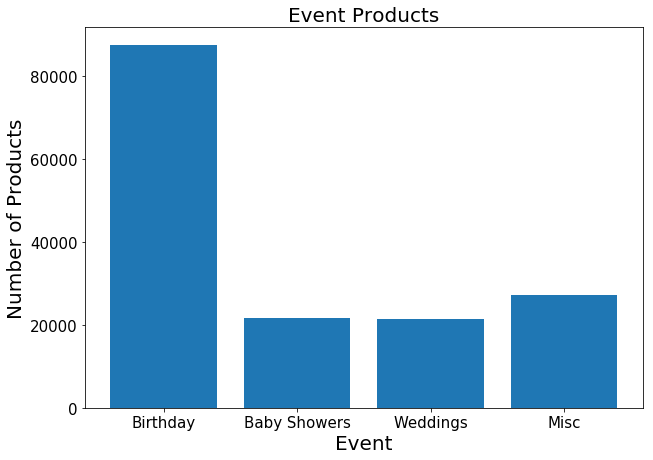

In [147]:
fig = plt.figure(figsize = (10, 7))
plt.title('Event Products', fontsize = 20)
plt.bar([0, 1, 2, 3], height = [birthday[0], baby_shower[0], wedding[0], misc[0]],
        tick_label = ['Birthday', 'Baby Showers', 'Weddings', 'Misc'])
plt.ylabel('Number of Products', fontsize = 20)
plt.xlabel('Event', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.savefig('cluster_title_popularity.png')
plt.show()

In [148]:
title_impress = X.groupby('title_cluster').agg({'total_impressions' : functions})
title_impress

total_impressions                                    
                           mean           std  count       max  min
title_cluster                                                      
0                   5644.906668  50958.280051  59840   3427298  100
1                  10183.211686  62452.441170  21428   2581557  100
2                   8999.082998  67261.496404  21603   2737341  100
3                   5487.039747  80854.327796  27549  10518678  100
4                   6972.280637  42701.768916  27295   3365593  100

In [149]:
counts = title_impress[[('total_impressions', 'mean')]]
birthday = counts.iloc[0] + counts.iloc[3]
baby_shower = counts.iloc[2]
wedding = counts.iloc[1]
misc = counts.iloc[4]
birthday, baby_shower, misc, wedding

(total_impressions  mean    11131.946415
 dtype: float64, total_impressions  mean    8999.082998
 Name: 2, dtype: float64, total_impressions  mean    6972.280637
 Name: 4, dtype: float64, total_impressions  mean    10183.211686
 Name: 1, dtype: float64)

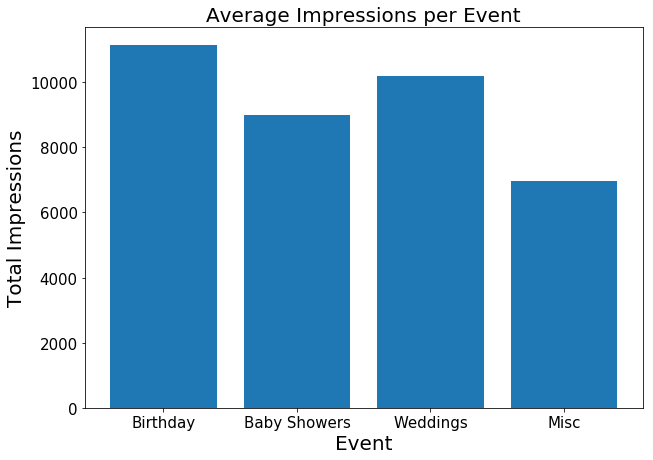

In [150]:
fig = plt.figure(figsize = (10, 7))
plt.title('Average Impressions per Event', fontsize = 20)
plt.bar([0, 1, 2, 3], height = [birthday[0], baby_shower[0], wedding[0], misc[0]],
        tick_label = ['Birthday', 'Baby Showers', 'Weddings', 'Misc'])
plt.ylabel('Total Impressions', fontsize = 20)
plt.xlabel('Event', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.savefig('cluster_title_impressions.png')
plt.show()

# Description Cluster Keys

0: Baby Shower
1: Baby Shower
2: Baby shower
3: Birthday
4: Wedding

In [151]:
descr_CTR = X.groupby('description_cluster').agg({'CTR' : functions})
descr_CTR

CTR                                     
                         mean       std  count       max       min
description_cluster                                               
0                    0.008077  0.006880  29951  0.115226  0.000225
1                    0.008675  0.007971  24252  0.128713  0.000131
2                    0.008692  0.007536  20867  0.113095  0.000277
3                    0.009219  0.008471  61389  0.152000  0.000145
4                    0.009112  0.007742  21256  0.100592  0.000283

In [152]:
counts = descr_CTR[[('CTR', 'count')]]
birthday = counts.iloc[3]
baby_shower = counts.iloc[0] + counts.iloc[1]
wedding = counts.iloc[4]
birthday, baby_shower, wedding

(CTR  count    61389
 Name: 3, dtype: int64, CTR  count    54203
 dtype: int64, CTR  count    21256
 Name: 4, dtype: int64)

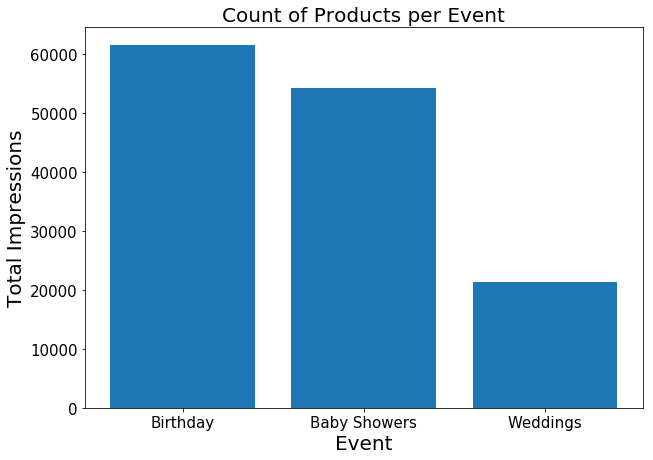

In [153]:
fig = plt.figure(figsize = (10, 7))
plt.title('Count of Products per Event', fontsize = 20)
plt.bar([0, 1, 2], height = [birthday[0], baby_shower[0], wedding[0]],
        tick_label = ['Birthday', 'Baby Showers', 'Weddings'])
plt.ylabel('Total Impressions', fontsize = 20)
plt.xlabel('Event', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.savefig('cluster_description_products.png')
plt.show()

In [154]:
descr_impress = X.groupby('description_cluster').agg({'total_impressions' : functions})
descr_impress

total_impressions                                    
                                 mean           std  count       max  min
description_cluster                                                      
0                         5057.732764  73245.802377  29951  10518678  100
1                         6665.131453  40810.772866  24252   3365593  100
2                        10647.881344  73574.225777  20867   2729768  100
3                         5320.424881  48842.687748  61389   5062025  100
4                        10817.806643  70512.726621  21256   3427298  100

In [155]:
counts = descr_impress[[('total_impressions', 'mean')]]
birthday = counts.iloc[3]
baby_shower = counts.iloc[0] + counts.iloc[1]
wedding = counts.iloc[4]
birthday, baby_shower, wedding

(total_impressions  mean    5320.424881
 Name: 3, dtype: float64, total_impressions  mean    11722.864217
 dtype: float64, total_impressions  mean    10817.806643
 Name: 4, dtype: float64)

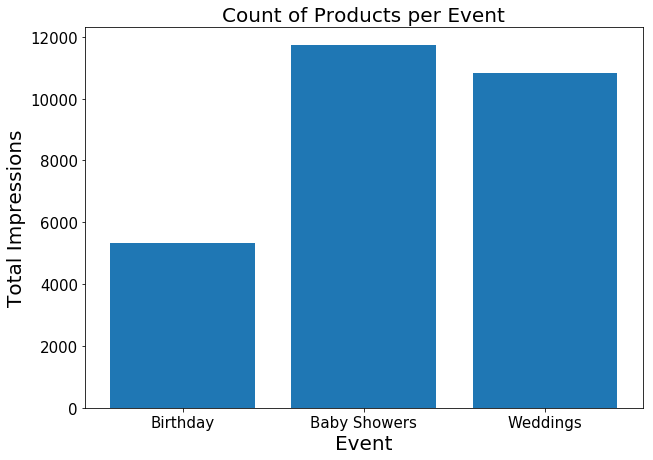

In [156]:
fig = plt.figure(figsize = (10, 7))
plt.title('Count of Products per Event', fontsize = 20)
plt.bar([0, 1, 2], height = [birthday[0], baby_shower[0], wedding[0]],
        tick_label = ['Birthday', 'Baby Showers', 'Weddings'])
plt.ylabel('Total Impressions', fontsize = 20)
plt.xlabel('Event', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.savefig('cluster_description_impressions.png')
plt.show()

In [157]:
copy.iloc[0].drop('CTR')

title                       Baby Girl Shower Invitation, Infant Unisex
description          2010 Socialite Designs. Tiny baby feet image a...
unitprice                                                          1.9
agegroup                                                        infant
material                                                           NaN
pattern                                                            NaN
label                                                     sold_locally
imagelink            https://rlv.zcache.com/baby_girl_shower_card-r...
score                                                      8.65982e-05
total_impressions                                                  256
total_clicks                                                         1
Name: 161928552431970573, dtype: object